In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Define paths
BASE_DIR = "/content/drive/MyDrive/PapilioNet"
DATASET_PATH = f"{BASE_DIR}/Dataset"
CSV_PATH = f"{BASE_DIR}/butterfly_species_info.csv"
MODEL_SAVE_PATH = f"{BASE_DIR}/finalHybridModel.keras"
CLASS_INDICES_PATH = f"{BASE_DIR}/class_indices.json"

In [3]:
!pip install tensorflow numpy pandas matplotlib seaborn opencv-python pillow scikit-learn

In [4]:
import os
import warnings
import json
import random
import numpy as np
import pandas
import tensorflow
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image, ImageEnhance
from tensorflow.keras.applications import EfficientNetB1, ResNet50
from tensorflow.keras.layers import (Input, GlobalAveragePooling2D, Dense, Dropout, Concatenate, Multiply, Reshape)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

warnings.filterwarnings("ignore")
sns.set(style="whitegrid")

In [5]:
def generate_class_indices():
    """Create class indices mapping from dataset folder."""
    class_folders = sorted(os.listdir(DATASET_PATH))
    class_indices = {class_name: idx for idx, class_name in enumerate(class_folders)}

    # Save class indices
    with open(CLASS_INDICES_PATH, "w") as f:
        json.dump(class_indices, f)

    return class_indices

# Load or generate class indices
if not os.path.exists(CLASS_INDICES_PATH):
    class_indices = generate_class_indices()
else:
    with open(CLASS_INDICES_PATH, "r") as f:
        class_indices = json.load(f)

# Reverse mapping: {index: species_name}
index_to_species = {v: k for k, v in class_indices.items()}

print("Class indices loaded:", class_indices)

Class indices loaded: {'Angled Castor': 0, 'Blue Tiger': 1, 'Chestnut Bob': 2, 'Clipper': 3, 'Commander': 4, 'Common Baron': 5, 'Common Crow Butterfly': 6, 'Common Grass Yellow': 7, 'Common Jezebel': 8, 'Common Leopard': 9, 'Common Mormon Swallowtail': 10, 'Common Palmfly': 11, 'Common Pierrot': 12, 'Common Tiger Butterfly': 13, 'Crimson Rose': 14, 'Glassy Tiger': 15, 'Great Eggfly': 16, 'Great Mormon': 17, 'Great Orange Tip': 18, 'Grey Pansy': 19, 'Lime Swallowtail': 20, 'Narrow-banded Bluebottle': 21, 'Painted Lady': 22, 'Peacock Pansy': 23, 'Red Pierrot': 24, 'Smooth-eyed Bushbrown': 25, 'Spotted Joker': 26, 'Tawny Coster': 27, 'Tiny Grass Blue': 28, 'White Four Ring': 29}


In [6]:
img_height, img_width = 224, 224
batch_size = 32

# Data Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=45,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.4,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    fill_mode="nearest"
)

train_data = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    subset="training"
)

val_data = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="categorical",
    subset="validation",
    shuffle=False
)

print(f"Training samples: {train_data.samples}, Validation samples: {val_data.samples}")

Found 13684 images belonging to 30 classes.
Found 3421 images belonging to 30 classes.
Training samples: 13684, Validation samples: 3421


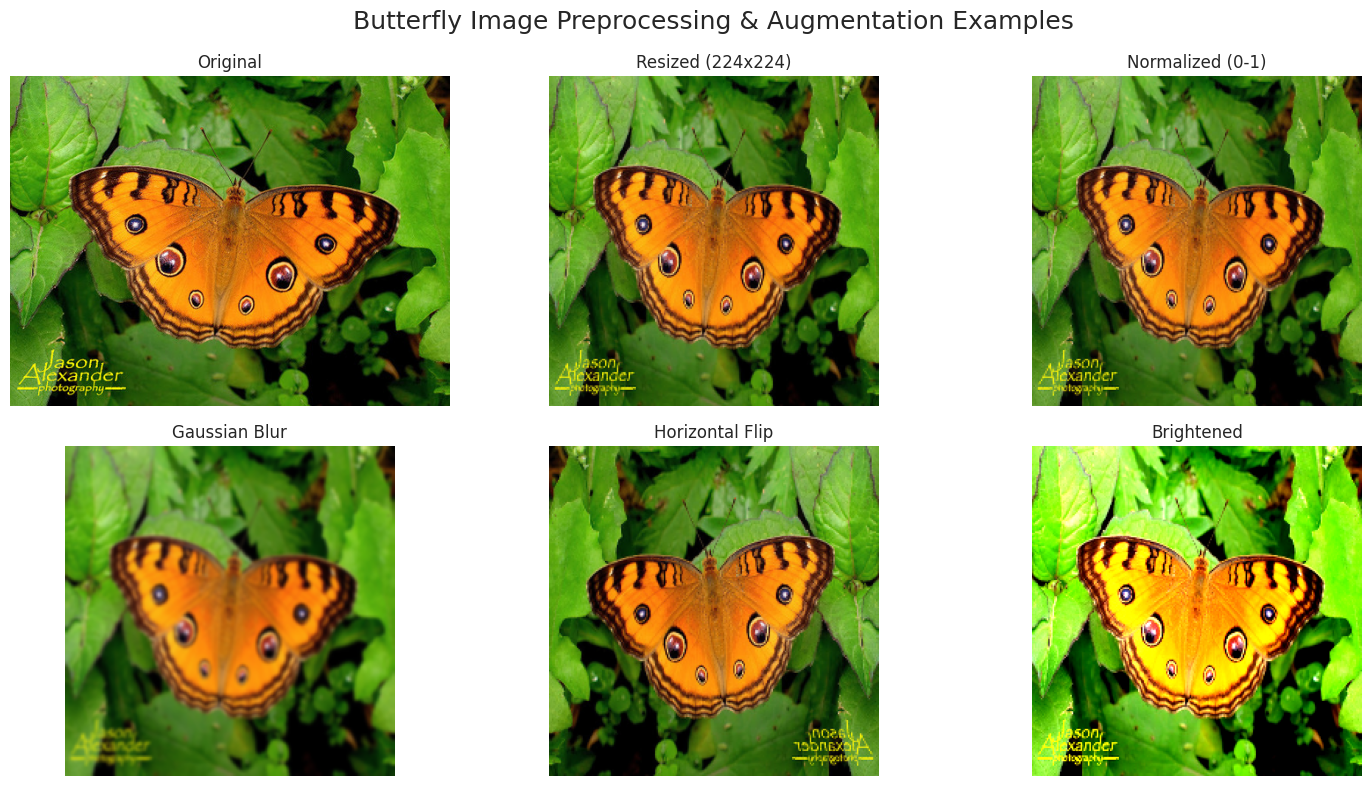

In [7]:
# Preprocess image manually (for visualization)
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    resized = cv2.resize(image, (img_height, img_width))
    normalized = resized / 255.0
    return image, resized, normalized

# Apply manual augmentations (for visualization)
def apply_augmentations(image):
    blur = cv2.GaussianBlur(image, (5, 5), 0)
    flip = cv2.flip(image, 1)
    pil_img = Image.fromarray(image)
    bright = ImageEnhance.Brightness(pil_img).enhance(1.5)
    contrast = ImageEnhance.Contrast(bright).enhance(1.2)
    bright_img = np.array(contrast)
    return blur, flip, bright_img

# Visualize Preprocessing
def visualize_preprocessing():
    # Random sample
    class_folders = [os.path.join(DATASET_PATH, folder) for folder in os.listdir(DATASET_PATH)]
    selected_folder = random.choice(class_folders)
    image_files = os.listdir(selected_folder)
    sample_image_path = os.path.join(selected_folder, random.choice(image_files))

    original, resized, normalized = preprocess_image(sample_image_path)
    blurred, flipped, brightened = apply_augmentations(resized)

    plt.figure(figsize=(15, 8))
    titles = ["Original", "Resized (224x224)", "Normalized (0-1)", "Gaussian Blur", "Horizontal Flip", "Brightened"]
    images = [original, resized, normalized, blurred, flipped, brightened]

    for i, (img, title) in enumerate(zip(images, titles)):
        plt.subplot(2, 3, i + 1)
        plt.imshow(img)
        plt.title(title)
        plt.axis("off")

    plt.suptitle("Butterfly Image Preprocessing & Augmentation Examples", fontsize=18)
    plt.tight_layout()
    plt.show()

# Show preprocessing visualization
visualize_preprocessing()

In [8]:
def squeeze_and_excitation_block(input_tensor, ratio=16):
    """Adds a Squeeze-and-Excitation (SE) block to the input tensor."""
    filters = input_tensor.shape[-1]
    se = GlobalAveragePooling2D()(input_tensor)
    se = Reshape((1, 1, filters))(se)
    se = Dense(filters // ratio, activation="relu")(se)
    se = Dense(filters, activation="sigmoid")(se)
    return Multiply()([input_tensor, se])

In [9]:
input_tensor = Input(shape=(img_height, img_width, 3))

# EfficientNetB1 branch
efficientnet = EfficientNetB1(weights="imagenet", include_top=False, input_tensor=input_tensor)
efficientnet_se = squeeze_and_excitation_block(efficientnet.output)
efficientnet_output = GlobalAveragePooling2D()(efficientnet_se)

# ResNet50 branch
resnet = ResNet50(weights="imagenet", include_top=False, input_tensor=input_tensor)
resnet_se = squeeze_and_excitation_block(resnet.output)
resnet_output = GlobalAveragePooling2D()(resnet_se)

# Combine both models
combined = Concatenate()([efficientnet_output, resnet_output])

# Fully connected layers
x = Dense(1024, activation="relu")(combined)
x = Dropout(0.5)(x)
output = Dense(train_data.num_classes, activation="softmax")(x)

model = Model(inputs=input_tensor, outputs=output)
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

27018416/27018416 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 34,335,221 (130.98 MB)

 Trainable params: 34,220,046 (130.54 MB)

 Non-trainable params: 115,175 (449.91 KB)

In [10]:
callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True),
    ModelCheckpoint(MODEL_SAVE_PATH, save_best_only=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=1e-6)
]

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=30,
    callbacks=callbacks
)

model.save(MODEL_SAVE_PATH)

Epoch 1/30
428/428 ━━━━━━━━━━━━━━━━━━━━ 4783s 11s/step - accuracy: 0.6501 - loss: 1.3323 - val_accuracy: 0.1462 - val_loss: 3.1824 - learning_rate: 1.0000e-04
Epoch 2/30
428/428 ━━━━━━━━━━━━━━━━━━━━ 323s 754ms/step - accuracy: 0.9451 - loss: 0.1896 - val_accuracy: 0.8217 - val_loss: 0.6924 - learning_rate: 1.0000e-04
Epoch 3/30
428/428 ━━━━━━━━━━━━━━━━━━━━ 331s 769ms/step - accuracy: 0.9629 - loss: 0.1291 - val_accuracy: 0.9404 - val_loss: 0.2085 - learning_rate: 1.0000e-04
Epoch 4/30
428/428 ━━━━━━━━━━━━━━━━━━━━ 338s 785ms/step - accuracy: 0.9692 - loss: 0.1101 - val_accuracy: 0.9465 - val_loss: 0.2003 - learning_rate: 1.0000e-04
Epoch 5/30
428/428 ━━━━━━━━━━━━━━━━━━━━ 329s 769ms/step - accuracy: 0.9718 - loss: 0.0919 - val_accuracy: 0.9360 - val_loss: 0.2513 - learning_rate: 1.0000e-04
Epoch 6/30
428/428 ━━━━━━━━━━━━━━━━━━━━ 323s 754ms/step - accuracy: 0.9769 - loss: 0.0734 - val_accuracy: 0.8483 - val_loss: 0.5320 - learning_rate: 1.0000e-04
Epoch 7/30
428/428 ━━━━━━━━━━━━━━━━━━━━ 3

In [11]:
val_predictions = np.argmax(model.predict(val_data), axis=1)
val_true = val_data.classes

# Compute Metrics
accuracy = accuracy_score(val_true, val_predictions)
precision = precision_score(val_true, val_predictions, average="weighted")
recall = recall_score(val_true, val_predictions, average="weighted")
f1 = f1_score(val_true, val_predictions, average="weighted")

print(f"Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")

107/107 ━━━━━━━━━━━━━━━━━━━━ 85s 675ms/step
Accuracy: 0.99, Precision: 0.99, Recall: 0.99, F1 Score: 0.99


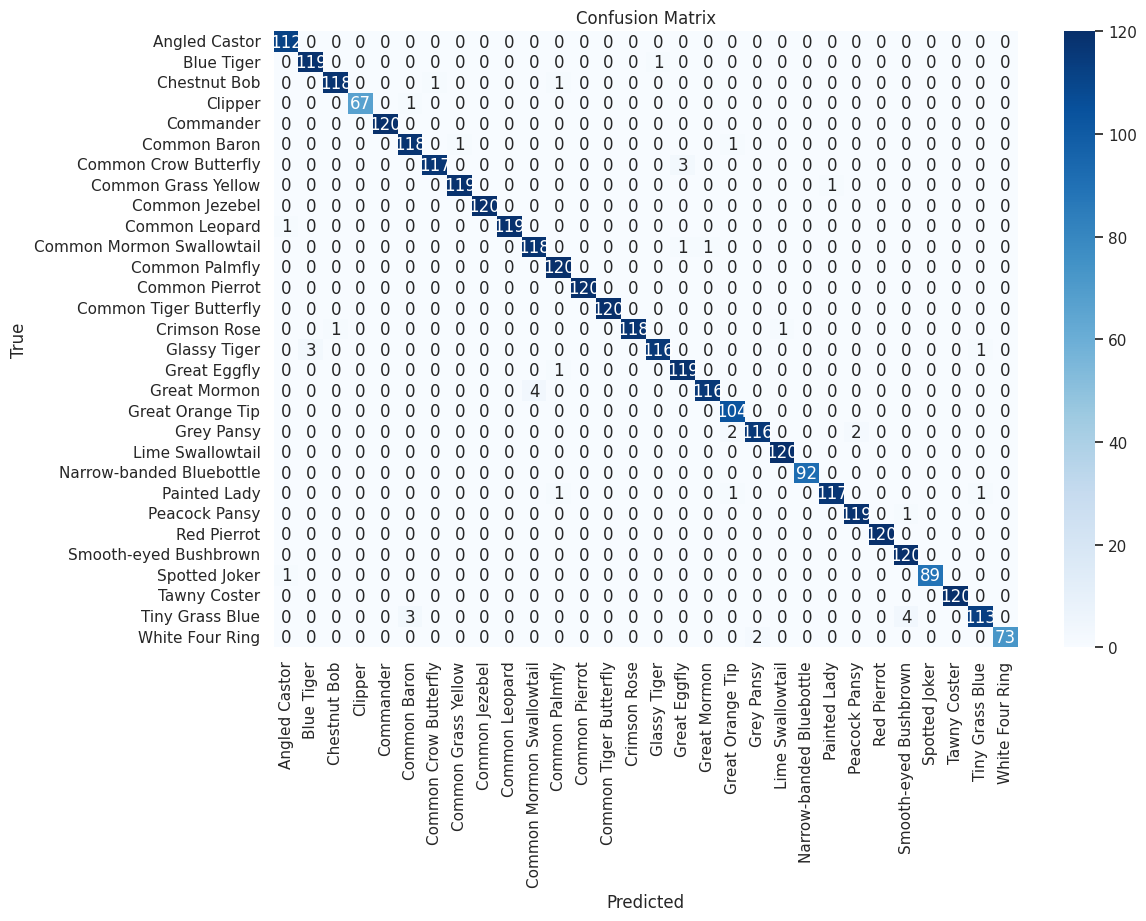

In [12]:
# Confusion Matrix
cm = confusion_matrix(val_true, val_predictions)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=list(train_data.class_indices.keys()), yticklabels=list(train_data.class_indices.keys()))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

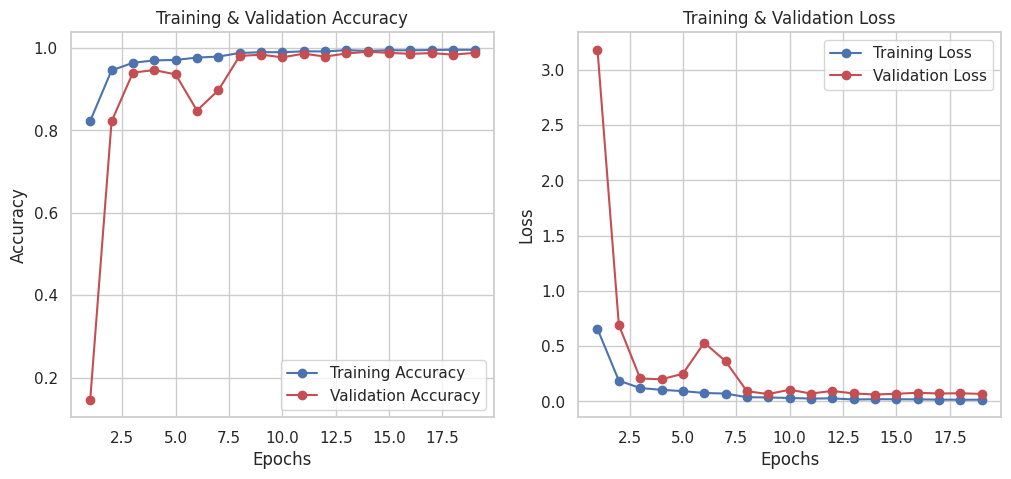

In [13]:
def plot_training_history(history):
    epochs = range(1, len(history.history["accuracy"]) + 1)

    # Plot Training & Validation Accuracy
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history["accuracy"], "bo-", label="Training Accuracy")
    plt.plot(epochs, history.history["val_accuracy"], "ro-", label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training & Validation Accuracy")
    plt.legend()

    # Plot Training & Validation Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history["loss"], "bo-", label="Training Loss")
    plt.plot(epochs, history.history["val_loss"], "ro-", label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()

    plt.show()

plot_training_history(history)

107/107 ━━━━━━━━━━━━━━━━━━━━ 60s 558ms/step


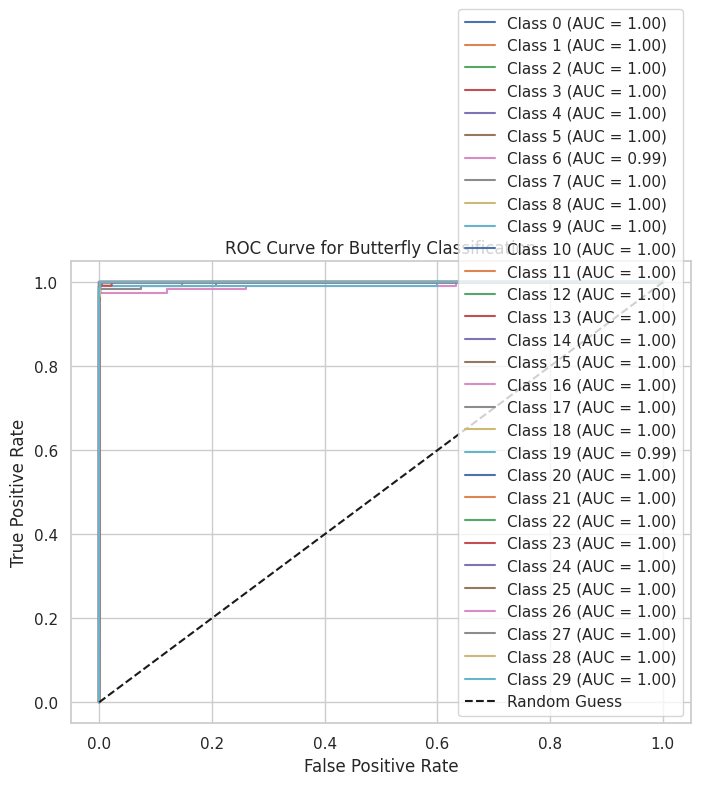

In [14]:
def plot_roc_curve(model, val_data):
    y_true = val_data.classes
    y_pred_probs = model.predict(val_data)
    num_classes = y_pred_probs.shape[1]

    # Binarize the true labels
    y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))

    # Plot ROC curve for each class
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

    # Plot diagonal line (random guess)
    plt.plot([0, 1], [0, 1], "k--", label="Random Guess")

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for Butterfly Classification")
    plt.legend(loc="lower right")
    plt.show()

plot_roc_curve(model, val_data)

In [15]:
# Generate classification report
class_labels = list(train_data.class_indices.keys())  # Class labels from training data
report = classification_report(val_true, val_predictions, target_names=class_labels)

print("\nClassification Report:")
print(report)


Classification Report:
                           precision    recall  f1-score   support

            Angled Castor       0.98      1.00      0.99       112
               Blue Tiger       0.98      0.99      0.98       120
             Chestnut Bob       0.99      0.98      0.99       120
                  Clipper       1.00      0.99      0.99        68
                Commander       1.00      1.00      1.00       120
             Common Baron       0.97      0.98      0.98       120
    Common Crow Butterfly       0.99      0.97      0.98       120
      Common Grass Yellow       0.99      0.99      0.99       120
           Common Jezebel       1.00      1.00      1.00       120
           Common Leopard       1.00      0.99      1.00       120
Common Mormon Swallowtail       0.97      0.98      0.98       120
           Common Palmfly       0.98      1.00      0.99       120
           Common Pierrot       1.00      1.00      1.00       120
   Common Tiger Butterfly       1.00 